<a href="https://colab.research.google.com/github/sbooeshaghi/intervals/blob/master/notebooks/elementary_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Determining elementary intervals

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict
from collections import OrderedDict
import random
import string

from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.patches as mpatches

from collections import defaultdict

def nd(arr):
    return np.asarray(arr).reshape(-1)

def yex(ax):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [201]:
def plot_itvs(intervals, lengths, vals, title, ax):
  xmin = min(intervals, key=lambda x: x[0])[0]
  xmax = max(intervals, key=lambda x: x[1])[1]
  for idx, itv in enumerate(intervals, 0):
    mid = itv[0] + lengths[idx]/2
    y = [idx, idx]

    ax.plot(itv, y)
    l, r = itv
    y1, y2 = y
    ax.scatter(l, y1, color="k", zorder=10)
    ax.scatter(r, y2, facecolors="none", edgecolors="k", zorder=10)

    ax.annotate(vals[idx], (mid, idx+0.1), ha="center")

  # ax.axvline(x=q, color="black")
  ax.grid(axis='x')

  kwd = {
      "yticks": range(len(vals)),
      "yticklabels": vals,
      "xticks": range(xmin, xmax+1),
      "xticklabels":range(xmin, xmax+1)
  }
  ax.set(**kwd)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.set_title(title)

  return ax

# Three steps

In [270]:
def gen_itv(minimum, maximum, min_len, max_len):
  lower = random.randint(minimum, maximum)
  upper = random.randint(lower, maximum)
  while upper - lower < min_len or upper - lower > max_len:
    upper = random.randint(lower, maximum)

  return (lower, upper)

def gen_itvs(minimum, maximum, min_len, max_len, n):
  itvs = []
  for i in range(n):
    itvs.append(gen_itv(minimum, maximum, min_len, max_len))
  return itvs

In [271]:
n_itvs = 10 # must be less than 26
max_pos = 20
min_pos = 0

min_len = 0
max_len = 20

intervals = gen_itvs(min_pos, max_pos, min_len, max_len, n_itvs)
lengths = [y-x for x, y in intervals]
values = [string.ascii_uppercase[i] for i in range(n_itvs)]

In [272]:
unsorted = intervals.copy()

lidx = sorted(range(len(intervals)), key=lambda k: intervals[k][0])
ridx = sorted(range(len(intervals)), key=lambda k: intervals[k][1])

l = sorted(intervals, key=lambda itv: itv[0])
r = sorted(intervals, key=lambda itv: itv[1])

llengths = [lengths[i] for i in lidx]
rlengths = [lengths[i] for i in ridx]

lvals = [values[i] for i in lidx]
rvals = [values[i] for i in ridx]

# Generating all elementary intervals for the simplest case

In [273]:
elem = []
vals = []
lst = []
for v, el in zip(lvals, l):
  left, right = el[0], el[1]

  if left not in elem:
    elem.append(left)

  if right not in elem:
    elem.append(right)


elem.sort()
elem_itv = [(elem[i-1], elem[i]) for i in range(1,len(elem))]
elem_len = [y-x for x, y in elem_itv]

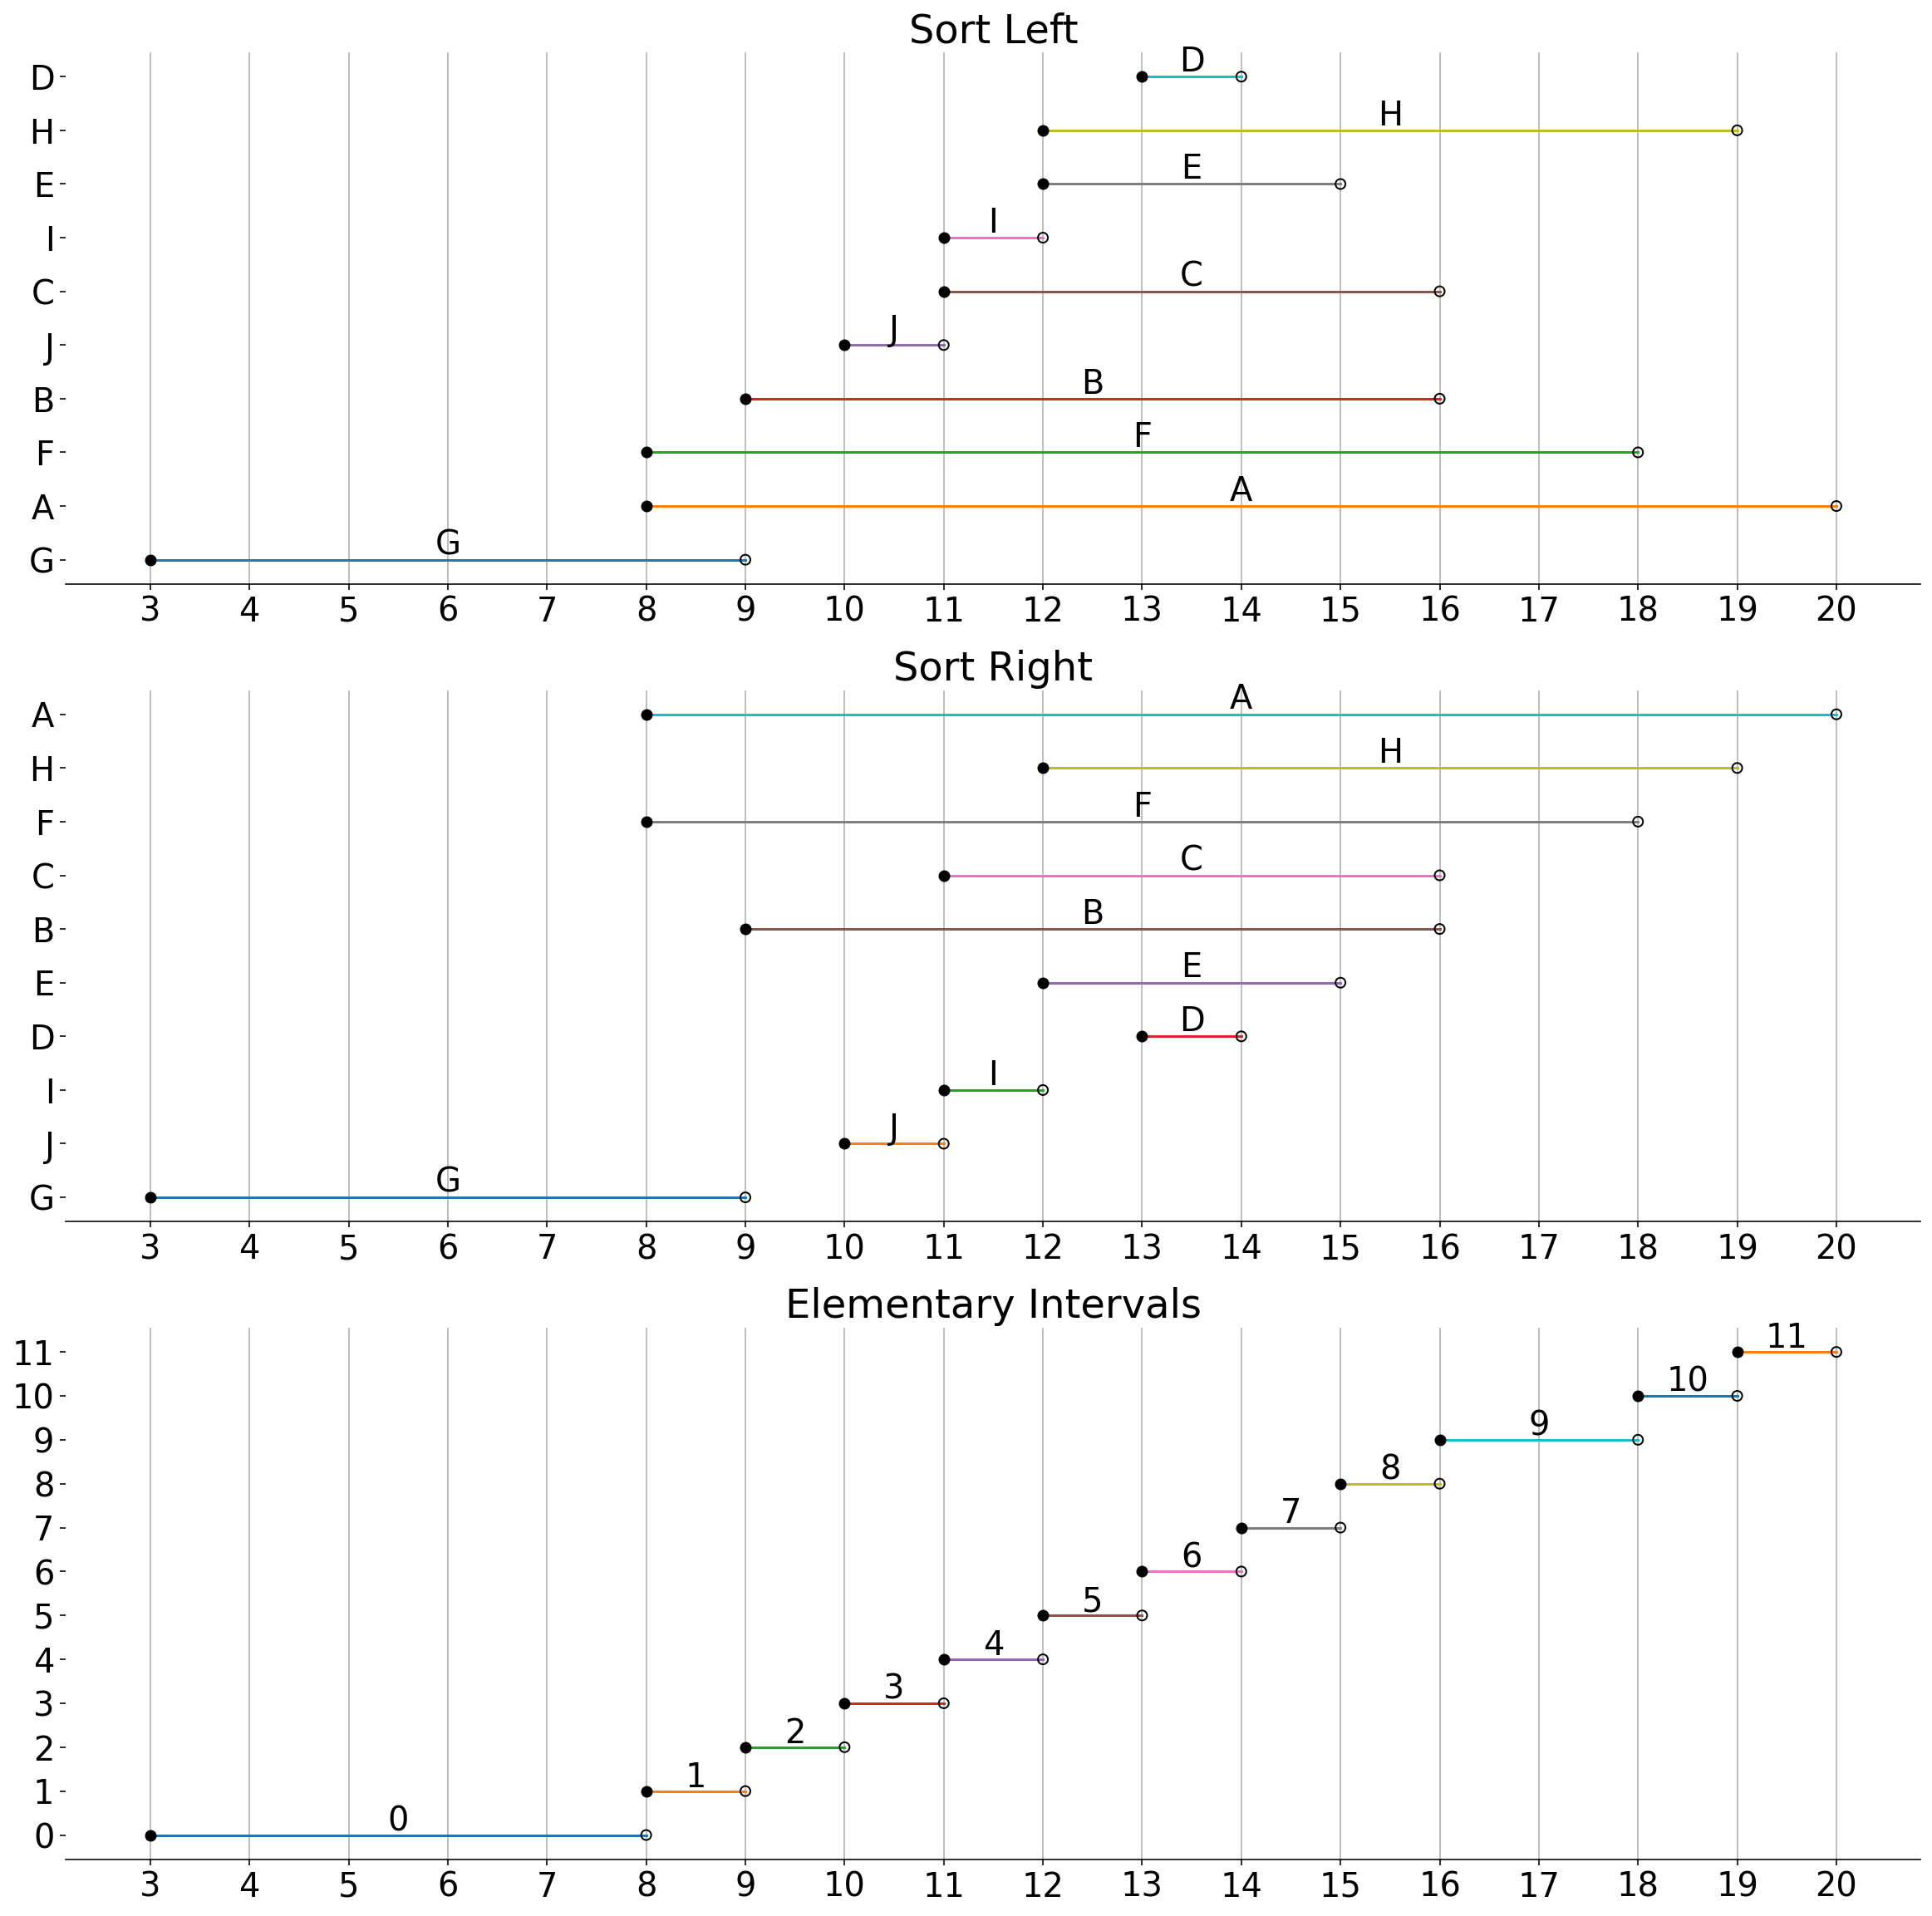

In [274]:
fig, ax = plt.subplots(figsize=(20,20), nrows=3)

plot_itvs(l, llengths, lvals, "Sort Left", ax[0])
plot_itvs(r, rlengths, rvals, "Sort Right", ax[1])
plot_itvs(elem_itv, elem_len, range(len(elem_itv)), "Elementary Intervals", ax[2])

fig.show()

In [275]:
print(l)
print(r)

[(3, 9), (8, 20), (8, 18), (9, 16), (10, 11), (11, 16), (11, 12), (12, 15), (12, 19), (13, 14)]
[(3, 9), (10, 11), (11, 12), (13, 14), (12, 15), (9, 16), (11, 16), (8, 18), (12, 19), (8, 20)]


# This is right end closed, left end open.

In [276]:
def get_elem_itvs(l, r, lvals, rvals):
  d = defaultdict(list)

  lidx = 0
  start = l[lidx][0] # left endpoint of first interval

  c = set()
  # for each right sorted endpoint
  for ridx in range(len(r)):
    # while still have intervals and left endpoint is less than right endpoint of new interval
    # ie L [a, b], R [c, d] => a < d
    c.add(rvals[ridx])
    while lidx < len(l) and l[lidx][0] <= r[ridx][1]:
      stop = l[lidx][0] # update stop to be left endpoint of L
      
      c.add(lvals[lidx])

      # if the left point of interval is greater than the start, its an elem interval
      if stop > start:
        c.add(rvals[ridx])
        d[(start, stop)] = c.copy()
        # update the start to be the stop of that interval
        start = stop
      
      lidx += 1
    # end of l intervals or. [a, b], [c, d] a >= d
    # if the prev interval and the current interval intersect at all
    if start < r[ridx][1]: 
      stop = r[ridx][1] # the stop is the end of that interval
      d[(start, stop)] = c.copy()
      start = stop 
    c.remove(rvals[ridx])

  return d

In [280]:
d = get_elem_itvs(l, r, lvals, rvals)

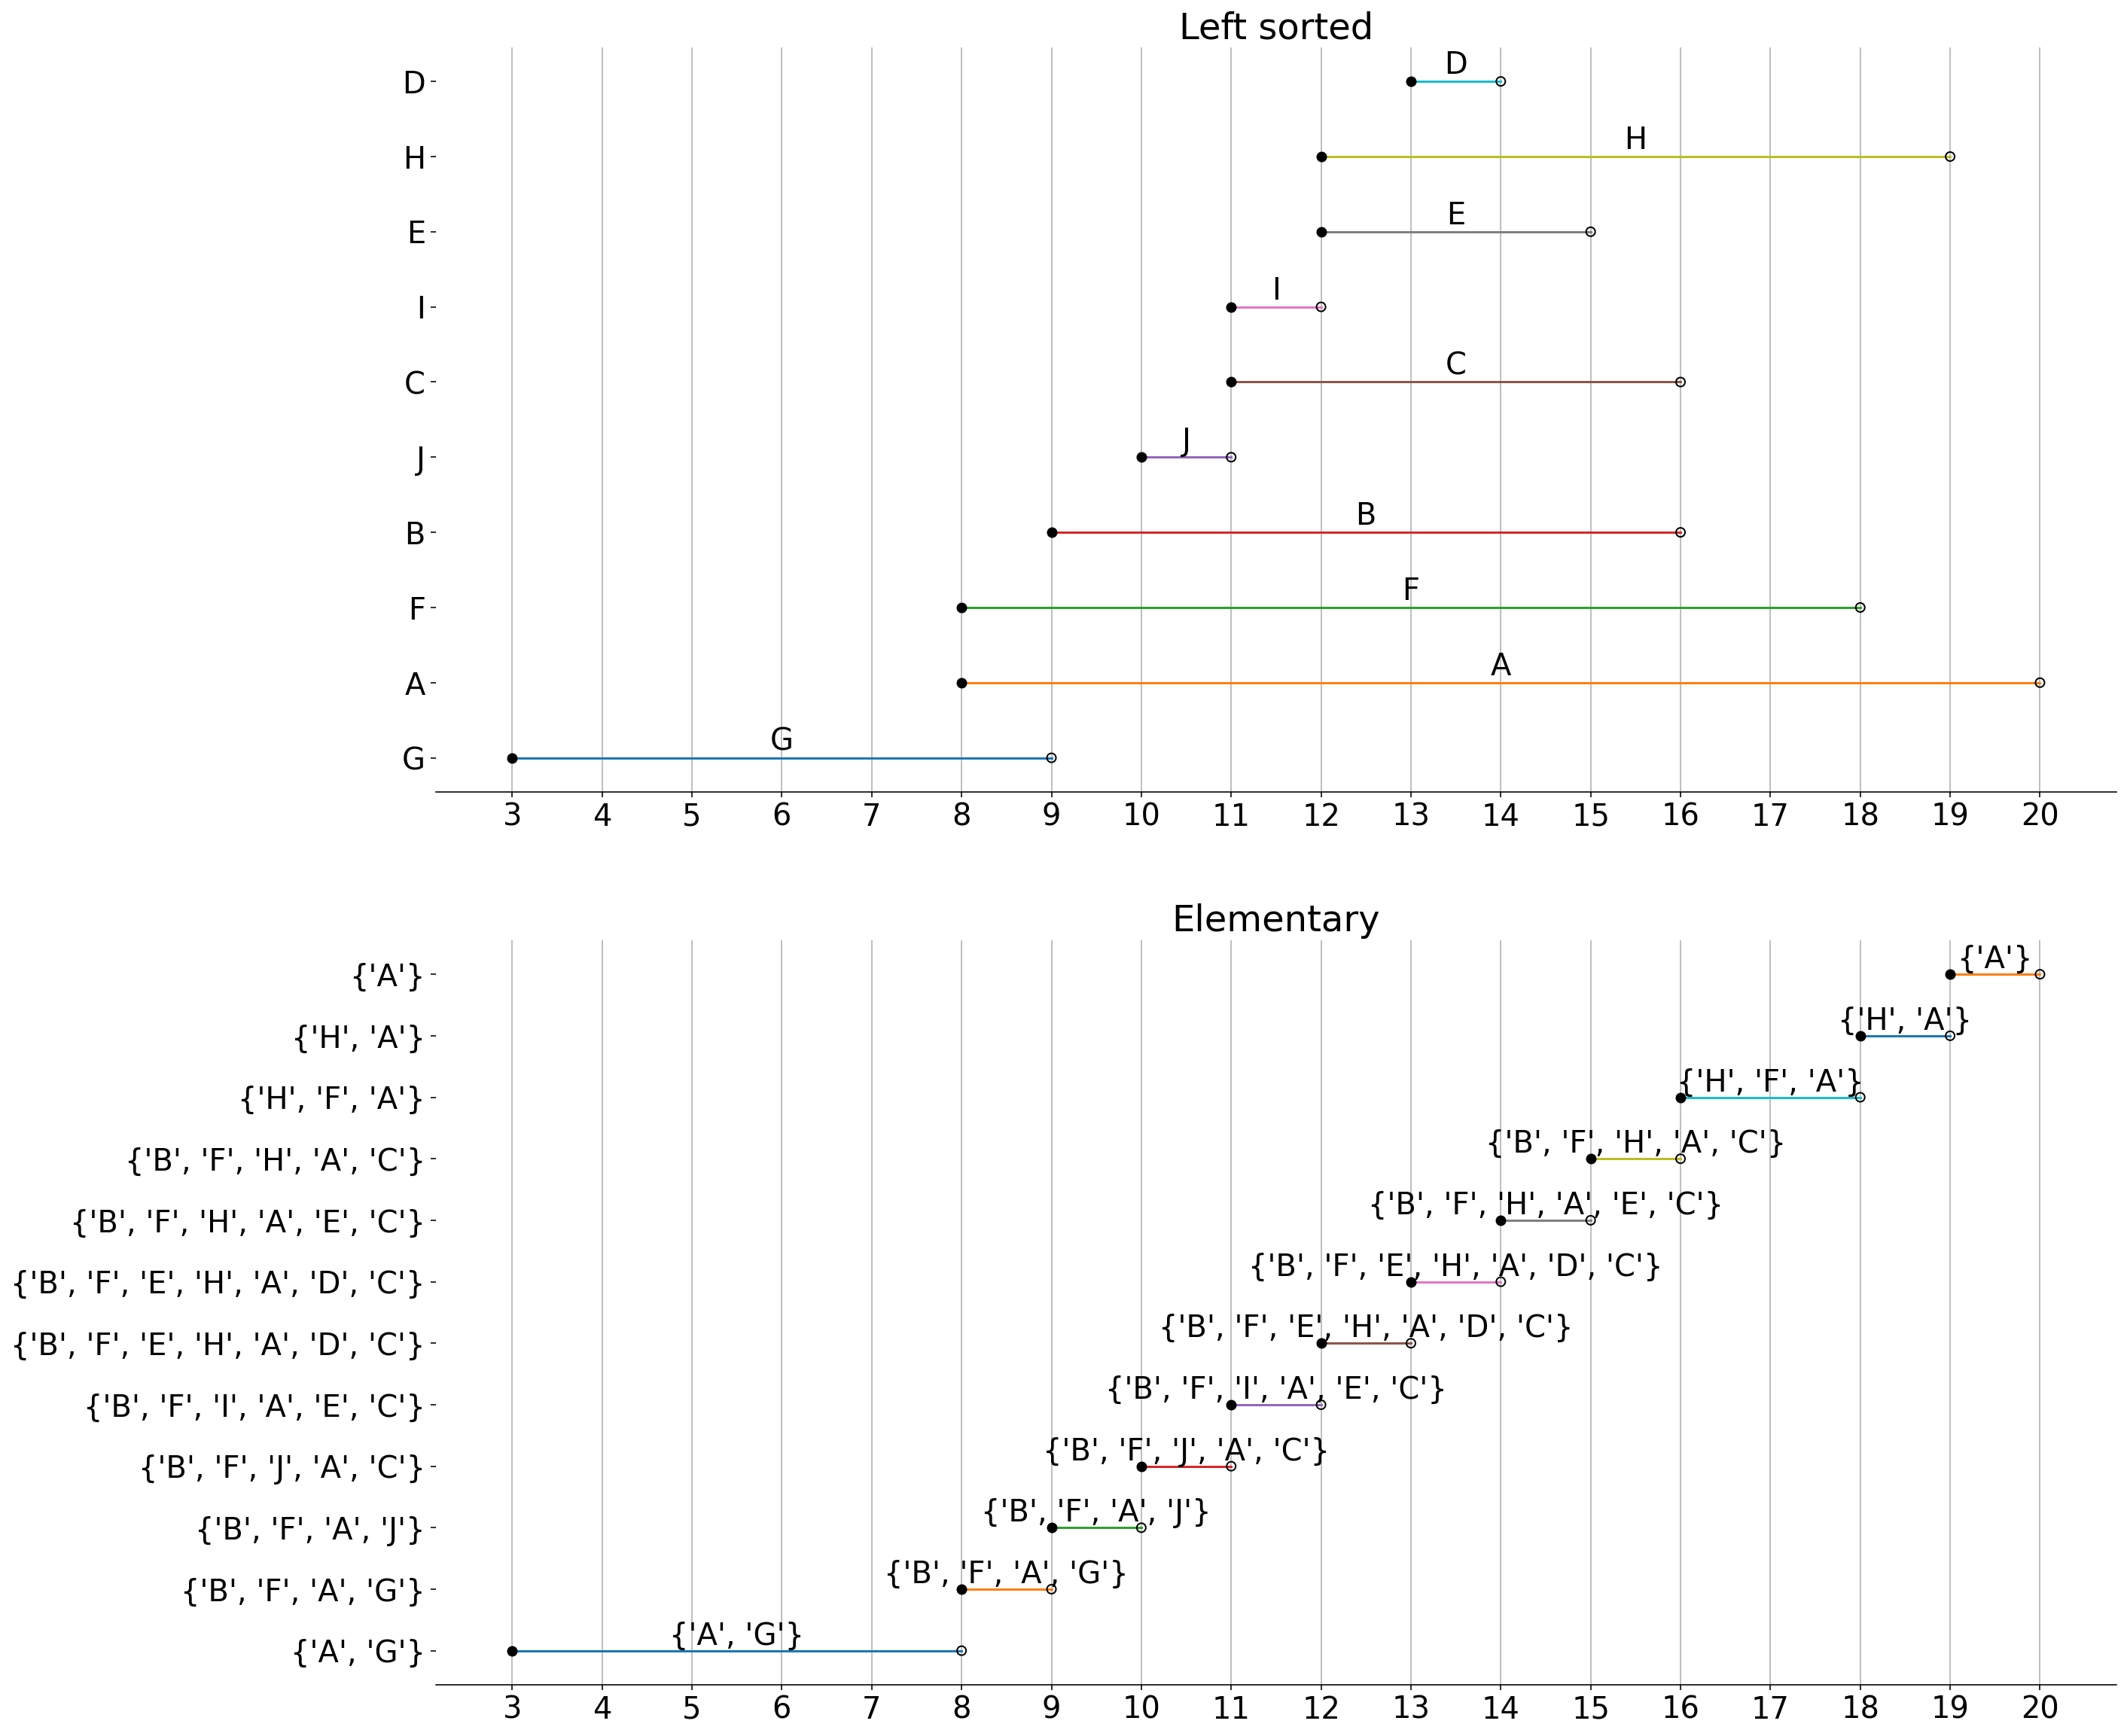

In [281]:
fig, ax = plt.subplots(figsize=(20,20), nrows=2)

itvs = list(d.keys())
vals = list(d.values())

plot_itvs(l, llengths, lvals, "Left sorted", ax[0])
plot_itvs(itvs, [y-x for x, y in itvs], vals, "Elementary", ax[1])

fig.show()

# Left end closed right end open

In [282]:
L = max_pos
rev = [(L-y, L-x) for x, y in intervals]

rev_lengths = [y-x for x, y in rev]

rev_rdx = sorted(range(len(rev)), key=lambda k: rev[k][0])
rev_ldx = sorted(range(len(rev)), key=lambda k: rev[k][1])

rev_l = sorted(rev, key=lambda itv: itv[0])
rev_r = sorted(rev, key=lambda itv: itv[1])

rev_llengths = [rev_lengths[i] for i in rev_rdx]
rev_rlengths = [rev_lengths[i] for i in rev_ldx]

rev_lvals = [values[i] for i in rev_rdx]
rev_rvals = [values[i] for i in rev_ldx]

In [288]:
d = get_elem_itvs(rev_l, rev_r, rev_lvals, rev_rvals)

In [289]:
drev = defaultdict()
for k, v in d.items():
  drev[(L-k[1], L-k[0])] = v

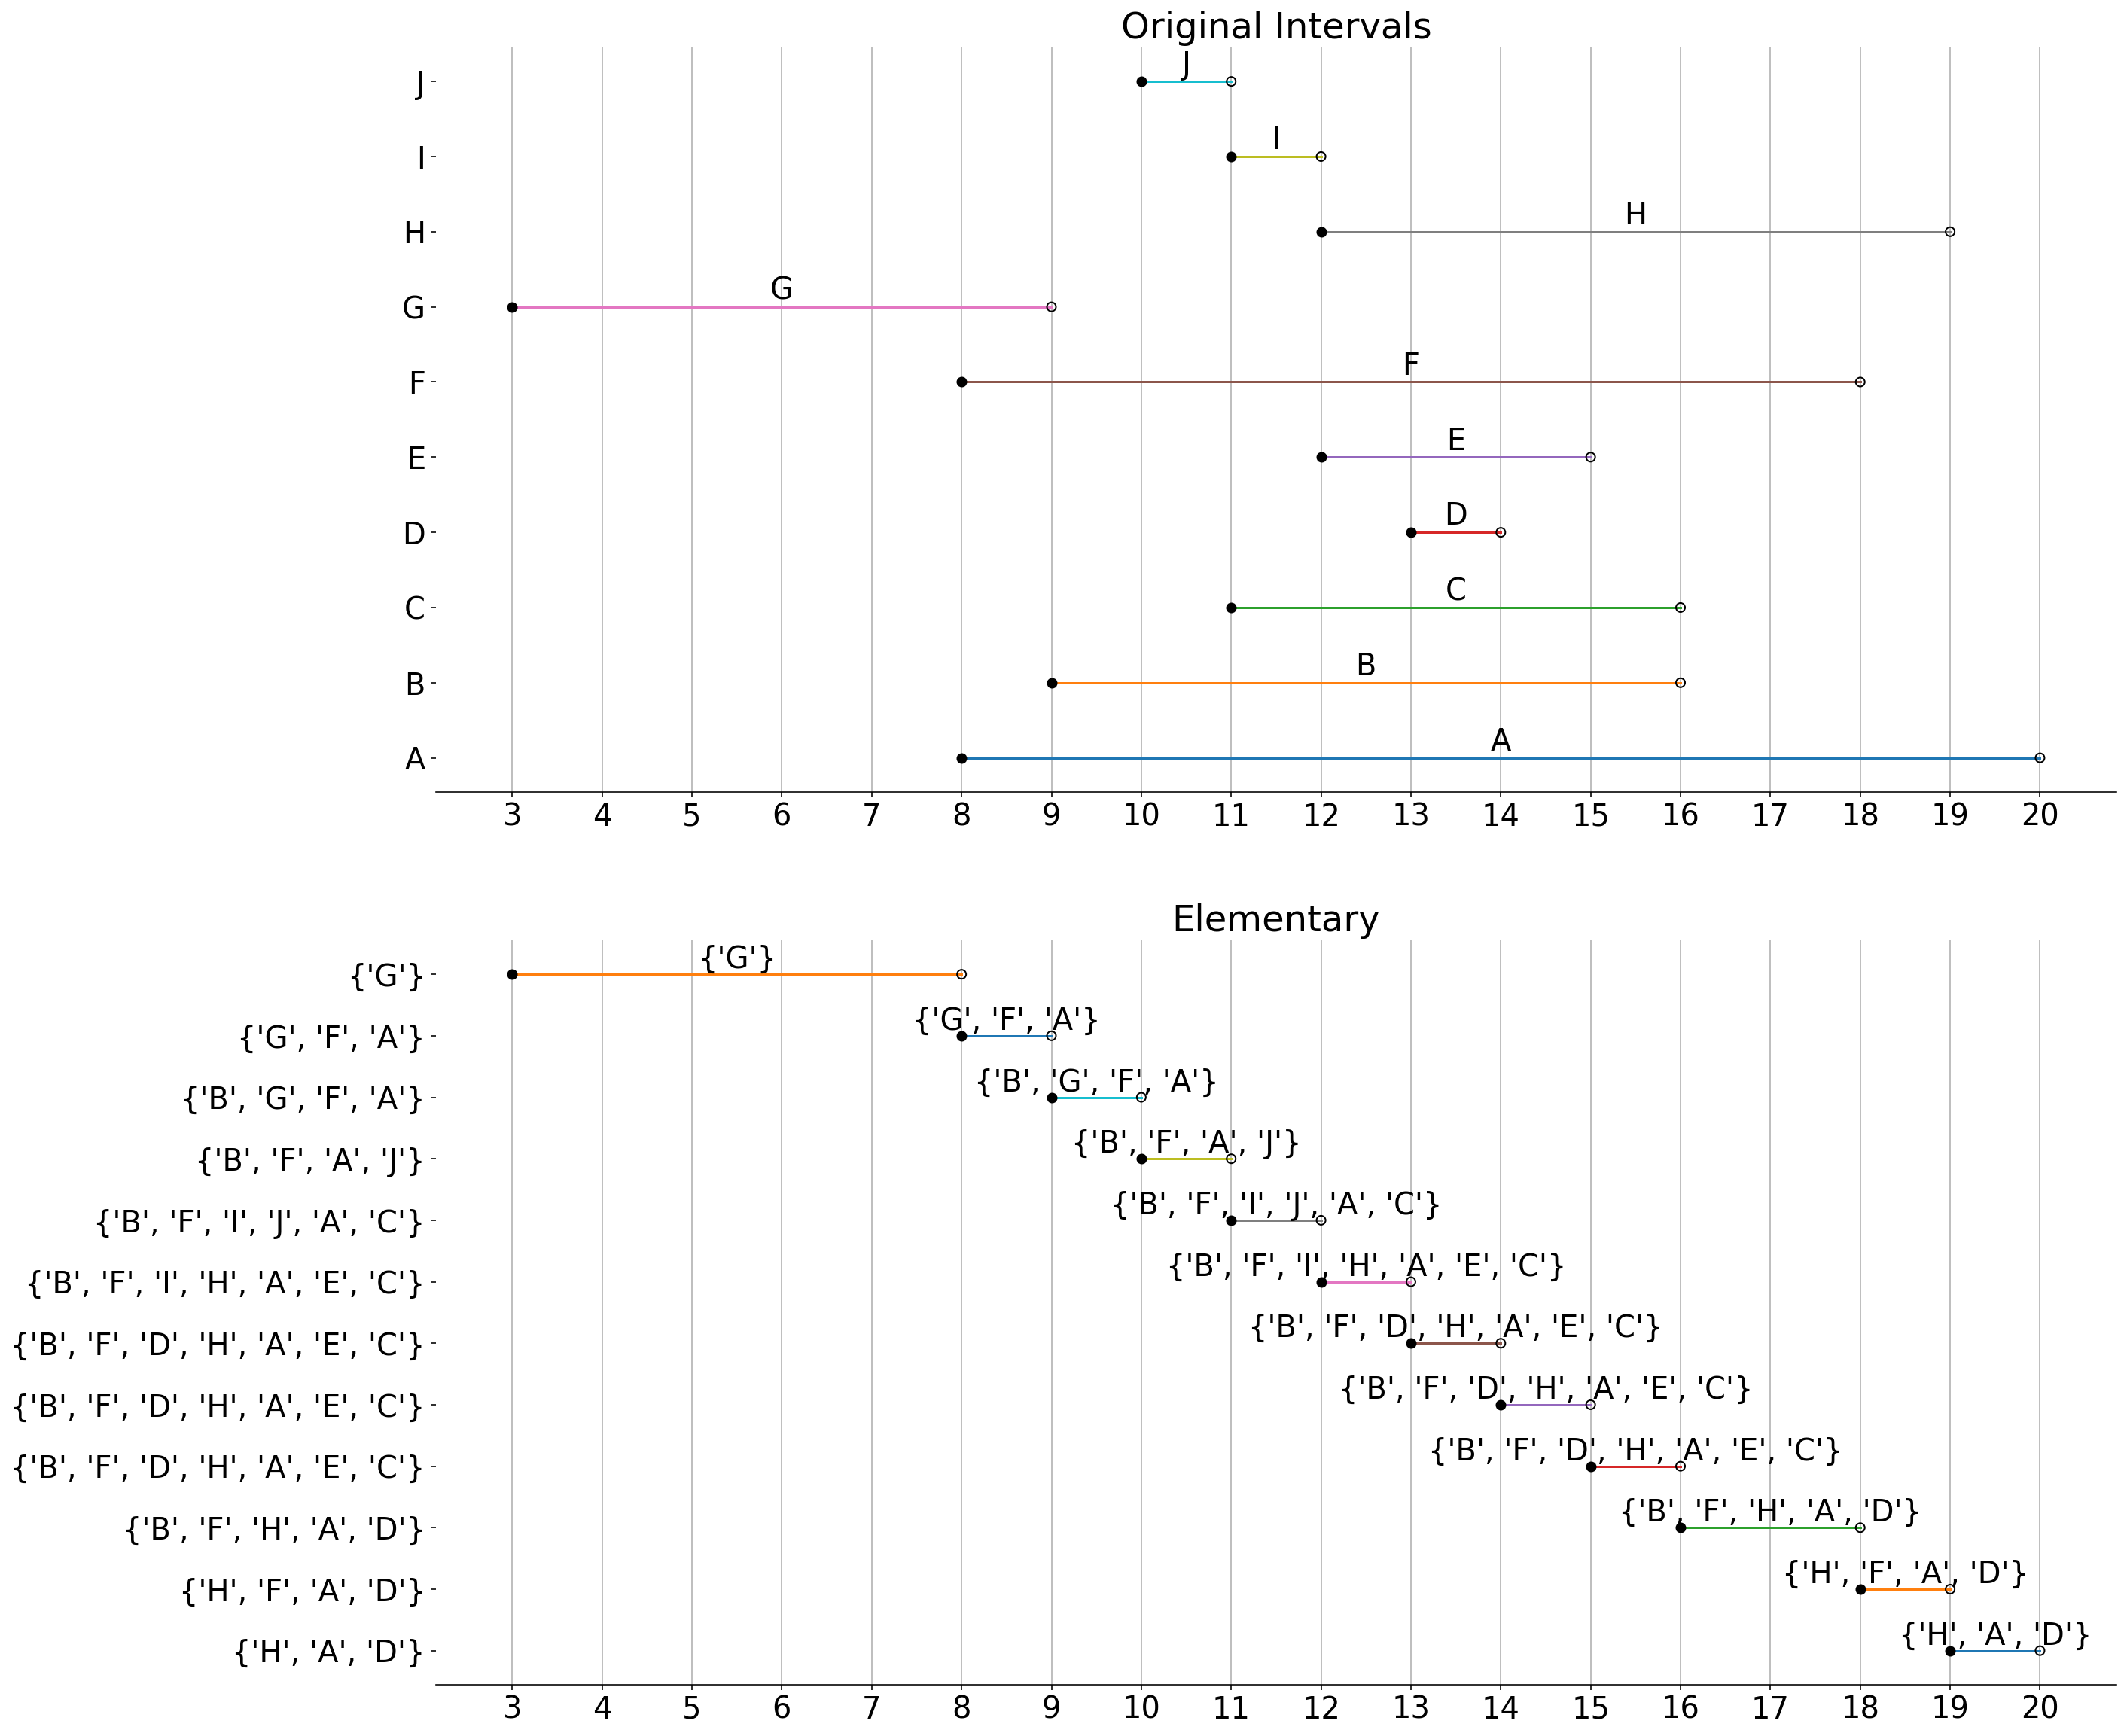

In [291]:
fig, ax = plt.subplots(figsize=(20,20), nrows=2)

itvs = list(drev.keys())
vals = list(drev.values())

plot_itvs(intervals, [y-x for x, y in intervals], values, "Original Intervals", ax[0])
plot_itvs(itvs, [y-x for x, y in itvs], vals, "Elementary", ax[1])

fig.show()